In [166]:
import math
from botorch.utils import t_batch_mode_transform
import torch
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models import  SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.monte_carlo import AcquisitionFunction
from botorch.optim.optimize import optimize_acqf
from botorch.optim.initializers import gen_batch_initial_conditions
from botorch.utils.transforms import normalize, unnormalize
from botorch.models.transforms.outcome import Standardize

#kernels
from gpytorch.kernels import RBFKernel, ScaleKernel

problem setting

penicillin

In [167]:
from botorch.test_functions.multi_objective import Penicillin
from botorch.utils.sampling import draw_sobol_samples
test_f = Penicillin(negate = True)
bounds = torch.tensor([[60,10,293,10,0.01,600,5],[120, 18, 303, 18, 0.1, 700, 6.5]], dtype= torch.float64)
def generate_initial_data(n):
    # generate training data
    train_x = draw_sobol_samples(bounds=bounds, n=n, q=1).squeeze(1)
    train_obj = test_f(train_x)
    return train_x, train_obj

acquisition

In [168]:
from botorch.acquisition import AnalyticAcquisitionFunction
import torch

class HyperVolumeScalarizedUCB(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model,
        beta: float,
        theta: torch.Tensor,
        ref: torch.Tensor,
        maximize: bool = True,
    ) -> None:
        """
        Initializes the HyperVolume Scalarized Upper Confidence Bound Acquisition Function.

        Args:
            model: A BoTorch model representing the posterior distribution of the objectives.
            beta (Tensor of shape [1] or [o]): The exploration-exploitation trade-off parameter(s).
            theta (Tensor of shape [o]): The weights used for scalarizing the upper bounds, where `o` is the number of objectives.
            maximize (bool): Whether to maximize or minimize the scalarized objective. Defaults to True (maximize).
        """
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("theta", torch.as_tensor(theta))
        self.register_buffer("ref", torch.as_tensor(ref))
    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the scalarized Upper Confidence Bound on the candidate set X.

        Args:
            X (Tensor of shape [b, d]): A tensor containing `(b)` batches of `d`-dimensional design points.

        Returns:
            Tensor of shape [b]: A tensor containing the scalarized Upper Confidence Bound values for each batch.
        """
        self.beta = self.beta.to(X)
        self.theta = self.theta.to(X)
        self.ref = self.ref.to(X)
        posterior = self.model.posterior(X)
        means = posterior.mean.squeeze(dim=-2)  # b x o
        std_devs = posterior.variance.squeeze(dim=-2).sqrt()  # b x o
        m = means.shape[1]
        # Calculate upper confidence bounds for each objective
        u_t = means + (self.beta.expand_as(means) * std_devs) - self.ref # b x o

        # Apply the scalarization function to the upper bounds
        scalarized_ut = torch.min(((u_t / self.theta) ** m), dim=-1)[0]  # b

        return scalarized_ut


Auxiliary Acq

In [169]:
class AuxiliaryAcq(MCAcquisitionFunction):
    def __init__(
        self,
        model,
        beta: float,
        theta: torch.Tensor,
        ref: torch.Tensor,
        maximize: bool = True,
    ) -> None:
        """
        An auxiliary acquisition defined in Algo.2

        Args:
            model: A BoTorch model representing the posterior distribution of the objectives.
            beta (Tensor of shape [1] or [o]): The exploration-exploitation trade-off parameter(s).
            theta (Tensor of shape [o]): The weights used for scalarizing the upper bounds, where `o` is the number of objectives.
            maximize (bool): Whether to maximize or minimize the scalarized objective. Defaults to True (maximize).
        """
        super(MCAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("theta", torch.as_tensor(theta))
        self.register_buffer("ref", torch.as_tensor(ref))
    @t_batch_mode_transform()
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the scalarized Upper Confidence Bound on the candidate set X.

        Args:
            X (Tensor of shape [b, d]): A tensor containing `(b)` batches of `d`-dimensional design points.

        Returns:
            Tensor of shape [b]: A tensor containing the scalarized Upper Confidence Bound values for each batch.
        """
        self.beta = self.beta.to(X)
        self.theta = self.theta.to(X)
        self.ref = self.ref.to(X)
        posterior = self.model.posterior(X)
        #print(posterior.mean.shape)
        means = posterior.mean  # b x q x o
        std_devs = posterior.variance.sqrt()  # b x q x o
        # Calculate upper confidence bounds for each objective
        u_t = means + (self.beta.expand_as(means) * std_devs) - self.ref # b x qx o
        #print('233', u_t.shape)

        # Apply the scalarization function to the upper bounds
        scalarized_ut = torch.min(torch.min(u_t, dim=-1)[0], dim=-1)[0]  # b
        return scalarized_ut


constraints

In [170]:
import torch
from typing import List, Tuple, Callable

def create_ucb_constraints(model, beta: float, thresholds: torch.Tensor):
    """
    Creates a list of non-linear inequality constraints for a multi-output GP model, ensuring that the upper confidence
    bounds of the model's outputs are greater than or equal to the specified thresholds.

    Args:
        model (MultiTaskGP): A multi-output Gaussian Process model.
        beta (float): The scalar coefficient for the variance component of the UCB.
        thresholds (torch.Tensor): A tensor of thresholds for each output dimension.

    Returns:
        List[Tuple[Callable, bool]]: A list of tuples, each containing a callable constraint and a boolean indicating
                                      whether the constraint is intra-point (True) or inter-point (False). Each callable
                                      takes a tensor `X` of shape [q, d] (where `d` is the dimension of the input space
                                      and `q` can be 1 or more representing different design points) and returns a scalar
                                      that should be non-negative if the constraint is satisfied.
    """
    
    def constraint(X):
        """
        Evaluates all constraints for a batch of design points.

        Args:
            X (torch.Tensor): A tensor of shape [q, d] (where `d` is the dimension of the input space and `q` can be 1 or more 
                              representing different design points).

        Returns:
            torch.Tensor: A tensor of shape [q, m] (where `m` is the number of output dimensions) containing the evaluated 
                          constraints.
        """
        # Compute posterior at X
        X = X.unsqueeze(0)
        posterior = model.posterior(X)
        mean = posterior.mean
        variance = posterior.variance
        ucb = mean + beta * variance.sqrt()  # Compute the UCB

        # Evaluate all constraints and return the difference from thresholds
        return ucb - thresholds

    # Create a list of constraints for each output dimension, all set as intra-point since they evaluate individually
    constraints = [(lambda X, i=i: constraint(X)[:, i], True) for i in range(thresholds.size(0))]

    return constraints


In [171]:
def get_random_sample_on_n_sphere(N, R):
    # Return a single sample of a vector of dimension N
    # with a uniform distribution on the (N-1)-Sphere surface of radius R.
    # RATIONALE: https://mathworld.wolfram.com/HyperspherePointPicking.html
    
    # Generate a normally distributed point
    X = torch.randn(N)

    # Normalize this point to the surface of the sphere, then scale by radius R
    return R * X / torch.norm(X)

BO loop

take thresholds to be: 10, -60, -350

approximated maximum HV(with 70 points): ~11000

kernel picking

In [172]:

from metrics import HV, violation

base = RBFKernel()
covar_module = ScaleKernel(
base_kernel=base,
)

sampler

In [173]:

def voxel_grid_sampling_with_indices(points, voxel_size = 5.0):
    # Calculate the minimum and maximum coordinates
    min_coords = torch.min(points, dim=0).values
    max_coords = torch.max(points, dim=0).values

    # Shift points so that the minimum coordinates are at the origin
    shifted_points = points - min_coords

    # Quantize the points to voxel grid coordinates
    voxel_indices = torch.floor(shifted_points / voxel_size).long()

    # Use a dictionary to store unique voxel indices and the corresponding row index
    voxel_dict = {}
    for idx, voxel_idx in enumerate(voxel_indices):
        voxel_idx_tuple = tuple(voxel_idx.tolist())
        if voxel_idx_tuple not in voxel_dict:
            voxel_dict[voxel_idx_tuple] = idx

    # Extract the row indices of the sampled points
    sampled_indices = torch.tensor(list(voxel_dict.values()))

    return sampled_indices



In [174]:
import warnings

warnings.filterwarnings('ignore')
import time
from platypus import NSGAII, Problem, Real, nondominated, experiment, calculate, display, ProcessPoolEvaluator
c = 0
thresholds = torch.tensor([10, -60, -350], dtype= torch.float64)
print('0'*50)
random_seeds = [83810, 14592, 3278, 97196, 36048, 32098, 29256, 18289, 96530, 13434, 88696, 97080, 71482, 11395, 77397, 55302, 4165, 3905, 12280, 28657, 30495, 66237, 78907, 3478, 73563,
26062, 93850, 85181, 91924, 71426, 54987, 28893, 58878, 77236, 36463, 851, 99458, 20926, 91506, 55392, 44597, 36421, 20379, 28221, 44118, 13396, 12156, 49797, 12676, 47052]
declared = False
for seed in random_seeds[:10]:
    torch.manual_seed(seed)
    train_X, train_Y = generate_initial_data(64)
    train_X = normalize(train_X, bounds)
    #obtain ~20 evenly distributed objective points
    resample_ind = voxel_grid_sampling_with_indices(train_Y)
    train_X = train_X[resample_ind, :]
    train_Y = train_Y[resample_ind, :]

    train_Xr, train_Yr = train_X, train_Y
    print(f'round{0}:', HV(Y = train_Y, ref = thresholds))
    Hpv = []
    Hpvr = []
    Acq = []
    NUM_ITER = 70
    for batch in range(NUM_ITER):
        '''t0 = time.monotonic()
        model_list = []
        m = 3
        for i in range(m):
            current_model = SingleTaskGP(train_X= train_X, train_Y= train_Y[:, i].unsqueeze(-1), outcome_transform= Standardize(m = 1), covar_module=covar_module, train_Yvar= torch.zeros((train_X.shape[0],1)) + 0.05**2)
            model_list.append(current_model)
        model = ModelListGP(*model_list)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
        #t1 = time.monotonic()
        #sample theta from distribution
        theta = get_random_sample_on_n_sphere(m,1).abs()
        beta = 0.1 * math.log((1+batch))
        beta_const = beta
        def acq_objective(X:list):
            X= torch.tensor([X])
            with torch.no_grad():
                posterior = model.posterior(X)
                mean = posterior.mean
                std = posterior.variance.sqrt()
                ucb_obj = mean + std * beta - thresholds
                ucb_const = mean + std * beta_const - thresholds
                acq = torch.min(torch.max(torch.zeros_like(ucb_obj), ucb_obj / theta) ** m, dim=-1)[0].cpu().tolist()
                ucb_const = ucb_const.cpu().numpy().squeeze(0).tolist()
                return acq, ucb_const
        prob = Problem(7, 1, 3)
        prob.types[:] = [Real(0,1)]*7
        prob.constraints[:] = '>=0'
        prob.function = acq_objective
        prob.directions[:] = Problem.MAXIMIZE
        algo = NSGAII(problem=prob, population_size= 1)
        algo.run(500)
        candidate = torch.tensor([list(sol.variables) for sol in algo.result])
        train_X = torch.cat([train_X, candidate],dim=0)
        train_Y = torch.cat([train_Y, test_f(unnormalize(candidate, bounds= bounds))], dim = 0)
        hv = HV(Y = train_Y, ref = thresholds)
        Hpv.append(hv)'''

        candidater, _ = generate_initial_data(1)
        candidater = normalize(candidater, bounds)
        train_Xr = torch.cat([train_Xr, candidater],dim=0)
        train_Yr = torch.cat([train_Yr, test_f(unnormalize(candidater, bounds= bounds))], dim = 0)
        hvr = HV(Y = train_Yr, ref = thresholds)
        Hpvr.append(hvr)

        #Acq.append(acq_scalar)
        #print(f'round {batch+1}',hv, 'random: ', hvr)
    if not declared:
        c+=1
        torch.save(torch.tensor(Hpvr), f'hv_peni_rand_{c}.pt')
        #torch.save(torch.tensor(Acq), f'acq_peni_rbf{c}.pt')
        torch.save(train_Yr, f'obj_peni_rbf_rand_{c}.pt')
        print('o', end='')
    else:
        print('*', end='')
    declared = False

00000000000000000000000000000000000000000000000000


round0: 3536.3583628954493
oround0: 5480.927172901254
oround0: 6036.305874260465
oround0: 7046.971281481402
oround0: 3988.6747049692476
oround0: 5274.654984746731
oround0: 4789.859052227031
oround0: 5693.765814432944
oround0: 6243.780648428599
oround0: 4678.081461665202
o

Text(0.5, 1.0, 'peni-CMOBO')

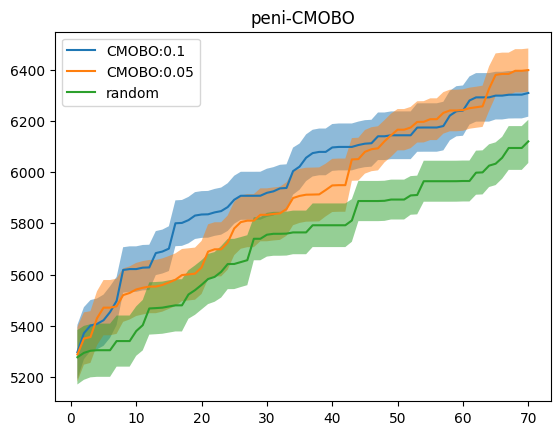

In [190]:
import matplotlib.pyplot as plt
data_01 = torch.zeros(10,70)
data_005 = torch.zeros(10,70)
data_r = torch.zeros(10,70)
for i in range(10):
    data_01[i,:] = torch.load(f'hv_peni_0.1_{i+1}.pt')
    data_005[i,:] = torch.load(f'hv_peni_0.05_{i+1}.pt')
    data_r[i,:] = torch.load(f'hv_peni_rand_{i+1}.pt')
mean01 = data_01.mean(dim = 0)
mean005 = data_005.mean(dim = 0)

std01 = data_01.std(dim = 0)
std005 = data_005.std(dim = 0)
stdr = data_r.std(dim = 0)
meanr = data_r.mean(dim = 0)
plt.plot(range(1,71), mean01)
plt.plot(range(1,71), mean005)
plt.plot(range(1,71), meanr)
plt.fill_between(range(1,71), mean01 - std01 * 0.1,mean01 + std01 * 0.1, alpha = 0.5)
plt.fill_between(range(1,71), mean005 - std005 * 0.1,mean005 + std005 * 0.1, alpha = 0.5)
plt.fill_between(range(1,71), meanr - stdr * 0.1,meanr + stdr * 0.1, alpha = 0.5)
plt.legend(['CMOBO:0.1', 'CMOBO:0.05', 'random'])
plt.title('peni-CMOBO')

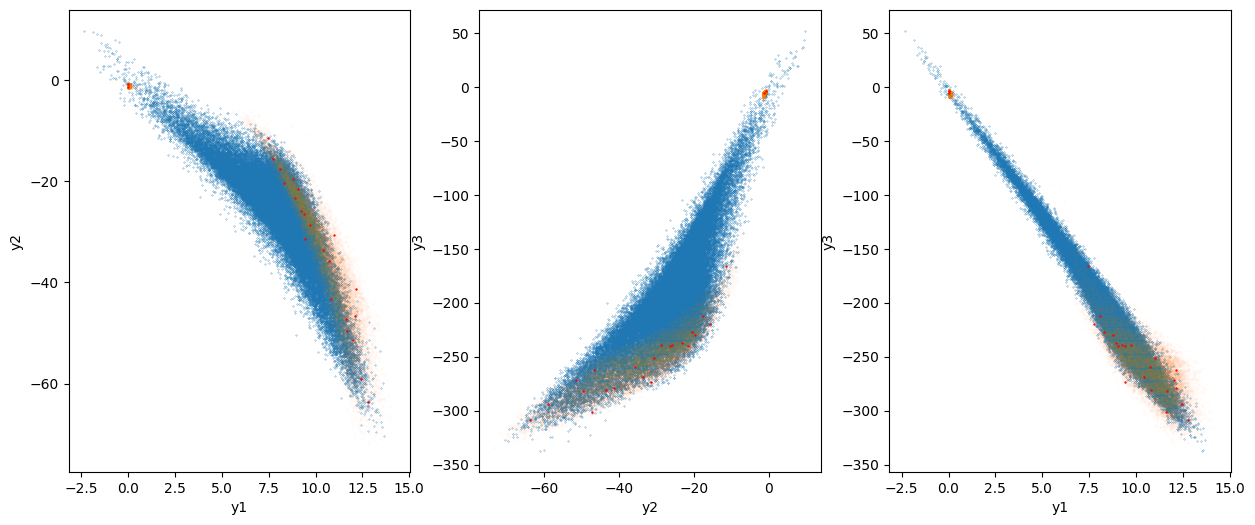

In [189]:
dom , obj= generate_initial_data(50000)
dom = normalize(dom, bounds)
with torch.no_grad():
    posterior = model.posterior(dom)
    mean = posterior.mean
    srd = posterior.variance.sqrt()
fig, ax = plt.subplots(1,3, figsize = (15, 6))
pair = [[0,1], [1,2], [0,2]]
for i in range(3):
    ls = pair[i]
    a = ls[0]
    b = ls[1]
    th1 = [5, -20, -100][a]
    th2 = [5, -20, -100][b]
    ax[i].scatter(mean[:,a].cpu().numpy(),mean[:,b].cpu().numpy(),s = 0.05,alpha = 1)
    ax[i].scatter(obj[:,a].cpu().numpy(),obj[:,b].cpu().numpy(),s = 0.1, alpha = 0.05)
    ax[i].scatter(train_Y[:,a], train_Y[:,b],s = 0.5, c ='red')
    ax[i].set_xlabel(f'y{a+1}')
    ax[i].set_ylabel(f'y{b+1}')

Text(0, 0.5, 'y3')

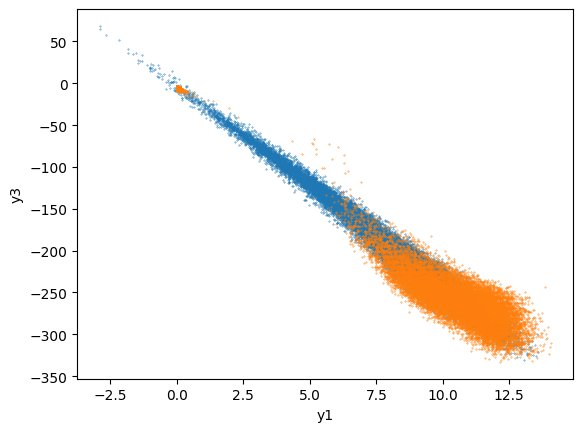

In [185]:
plt.scatter(mean[:,0].cpu().numpy(),mean[:,2].cpu().numpy(),s = 0.1)
plt.scatter(obj[:,0].cpu().numpy(),obj[:,2].cpu().numpy(),s = 0.1)
plt.xlabel('y1')
plt.ylabel('y3')

Text(0, 0.5, 'y3')

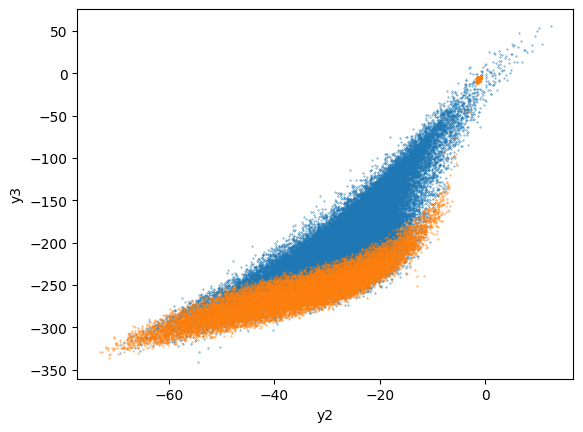

In [178]:
plt.scatter(mean[:,1].cpu().numpy(),mean[:,2].cpu().numpy(),s = 0.1)
plt.scatter(obj[:,1].cpu().numpy(),obj[:,2].cpu().numpy(),s = 0.1)
plt.xlabel('y2')
plt.ylabel('y3')

In [179]:
obj.max(dim = 0)

torch.return_types.max(
values=tensor([14.0728, -0.7011, -3.0000], dtype=torch.float64),
indices=tensor([25425, 41380,    79]))